In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

### Spergel scarlet fitting errors

In [4]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:5000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
meas_cat = vstack([Table.read(file) for file in files])
params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:5000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
print('Incomplete files:', np.sum(bad_flag))
print('Failed modelings:', np.isnan(meas_cat['rhalf_circularized']).sum())
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
# print('Surface brightness cut:', np.sum(~(params_cat['SB_eff_g'] > 28)))
# bad_flag |= (params_cat['SB_eff_g'] > 28)
print('Spergel size cut:', np.sum(~(meas_cat['rhalf_spergel'] * 0.168 < 1.5)))
bad_flag |= (meas_cat['rhalf_spergel'] * 0.168 < 1.5)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]

print('Number of survived objs afterall:', len(obj_cat))

meas_cat['rhalf_spergel'] = 0.168 * meas_cat['rhalf_spergel']
meas_cat['rhalf_circularized'] = 0.168 * meas_cat['rhalf_circularized']
meas_cat['sersic_rhalf'] = 0.168 * meas_cat['sersic_rhalf']

Total number of objects: 5000
Incomplete files: 81
Failed modelings: 0
Spergel size cut: 4887
Number of survived objs afterall: 4859


In [76]:
re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

spergel_nu = meas_cat['spergel_nu'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

ell_truth = params_cat['ellip'].data
ell_meas = meas_cat['ell_sym'].data

# SB
SB_meas = {}
SB_truth = {}
SB_meas['g'] = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth['g'] = params_cat['SB_eff_g'].data
SB_meas['r'] = meas_cat['SB_eff_avg'].data[:, 1]
SB_truth['r'] = SB_truth['g'] - params_cat['g-r'].data
SB_meas['i'] = meas_cat['SB_eff_avg'].data[:, 2]
SB_truth['i'] = SB_truth['g'] - params_cat['g-i'].data

# Color
gi_truth = params_cat['g-i'].data
gi_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]).data
gr_truth = params_cat['g-r'].data
gr_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]).data
# ri_truth = params_cat['g-i'].data - params_cat['g-r'].data
# ri_meas = (meas_cat['mag'][:, 1] - meas_cat['mag'][:, 2]).data

# Mag
mag_meas = {}
mag_truth = {}
mag_meas['g'] = meas_cat['mag'][:, 0].data
mag_meas['r'] = meas_cat['mag'][:, 1].data
mag_meas['i'] = meas_cat['mag'][:, 2].data
mag_truth['g'] = params_cat['mag_g'].data
mag_truth['r'] = params_cat['mag_g'] - params_cat['g-r'].data
mag_truth['i'] = params_cat['mag_g'] - params_cat['g-i'].data

-0.8180184691546317 1.5948346380443625


### Three methods
1. Train a nueral net to predict truth for each mock galaxy.
    For this method, bias correction works very well, but it will be hard to derive std using this method. Std requires binning anyway. 
    
2. Bin the parameter space, calculate `delta = (meas - truth) / meas`, then fit a polynomial for delta as a function of parameters.
    This would work fine?
    
3. same as 2, but replace the polynomial with a neural net.  

We should work on relative bias, not absolute one. 

Also, derive the bias in mag using SB? or vice versa?

### Method 3

In [77]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
from scipy.stats import binned_statistic_dd
from sample_cuts import quant_measurement, quant_error
import joblib
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

### R_e

In [195]:
kz.set_matplotlib(style='JL', usetex=True, dpi=50, fontsize=15)

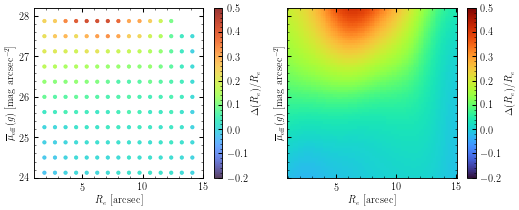

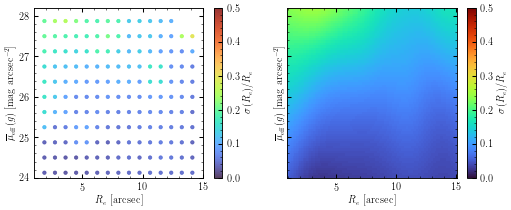

In [196]:
re_bias_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (re_truth - re_meas) / re_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='median',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=0.5, cbar_label=r'$\Delta(R_e)/R_e$'
)
re_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (re_truth - re_meas) / re_truth,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=0.02,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.5, cbar_label=r'$\sigma(R_e)/R_e$'
)

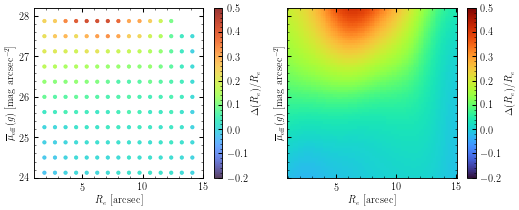

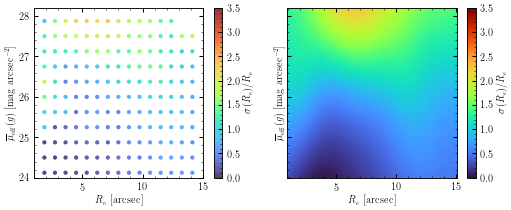

In [205]:
re_bias_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (re_truth - re_meas) / re_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='median',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=0.5, cbar_label=r'$\Delta(R_e)/R_e$'
)

re_meas_corr = re_meas * (1 + re_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T))
re_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (re_truth - re_meas_corr),
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=0.02,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=3.5, cbar_label=r'$\sigma(R_e)/R_e$'
)

0.013596707802182806 1.3411625571941101


(2.0, 15.0)

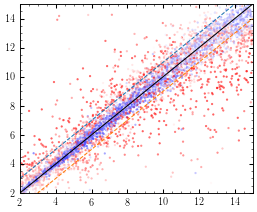

In [206]:
re_meas_corr = re_meas * (1 + re_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T))
re_meas_std = re_std_rbf(np.vstack([re_meas, SB_meas['g']]).T)
re_meas_std[re_meas_std < 0.3] = 0.3

print(np.median(re_meas_corr - re_truth), np.std(re_meas_corr - re_truth))

plt.scatter(re_truth, re_meas_corr, 
#             c=SB_truth['g'],
            c=re_meas_std,
            cmap='bwr',
            vmin=0, vmax=2,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x, c='k')
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.xlim(2, 15)
plt.ylim(2, 15)

0.013596707802182806 1.3411625571941101


(2.0, 15.0)

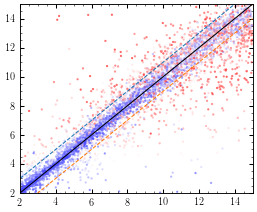

In [198]:
re_meas_corr = re_meas * (1 + re_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T))
re_meas_std = re_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * re_meas_corr
re_meas_std[re_meas_std < 0.3] = 0.3

print(np.median(re_meas_corr - re_truth), np.std(re_meas_corr - re_truth))

plt.scatter(re_truth, re_meas_corr, 
#             c=SB_truth['g'],
            c=re_meas_std,
            cmap='bwr',
            vmin=0, vmax=2,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x, c='k')
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [207]:
# joblib.dump(re_bias_rbf, './Catalog/mock_sample/spergel/bias_std/re_bias_rbf.pkl')
joblib.dump(re_std_rbf, './Catalog/mock_sample/spergel/bias_std/re_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/re_std_rbf.pkl']

### Surface brightness

In [83]:
SB_meas_corr = {}
SB_meas_std = {}

In [84]:
filt = 'g'

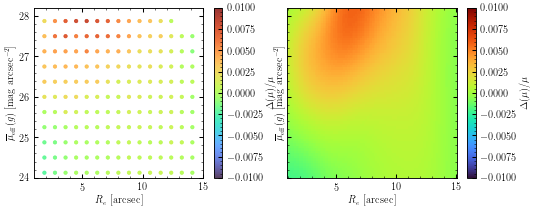

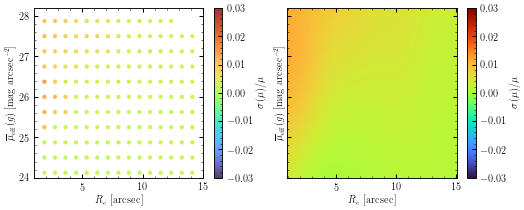

In [85]:
SB_bias_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (SB_truth[filt] - SB_meas[filt]) / SB_meas[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='median',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.01, vmax=0.01, cbar_label=r'$\Delta(\mu)/\mu$'
)

SB_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (SB_truth[filt] - SB_meas[filt]) / SB_truth[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.03, vmax=0.03, cbar_label=r'$\sigma(\mu)/\mu$'
)

(23.0, 29.0)

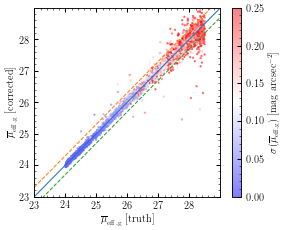

In [88]:
SB_meas_corr[filt] = SB_meas[filt] * (1 + SB_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T))
SB_meas_std[filt] = SB_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * SB_meas_corr[filt]
SB_meas_std[filt][SB_meas_std[filt] < 0.05] = 0.05

plt.scatter(SB_truth[filt], SB_meas_corr[filt], 
            c=SB_meas_std[filt], 
            cmap='bwr',
            vmin=0.,
            vmax=0.25,
            s=5, alpha=0.5)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.xticks(ticks=np.arange(23, 29, 1))
plt.yticks(ticks=np.arange(23, 29, 1))
plt.colorbar(label=r'$\sigma(\overline{\mu}_{\rm eff, ' + filt + '})$ [mag arcsec$^{-2}$]')
plt.xlabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [truth]')
plt.ylabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [corrected]')
plt.xlim(23, 29)
plt.ylim(23, 29)

In [89]:
joblib.dump(SB_bias_rbf, f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_bias_rbf.pkl')
joblib.dump(SB_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_g_std_rbf.pkl']

### Color

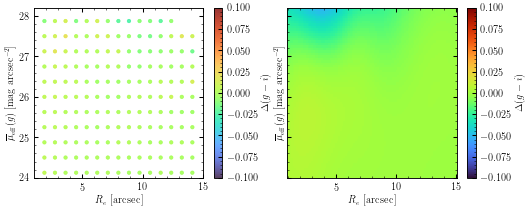

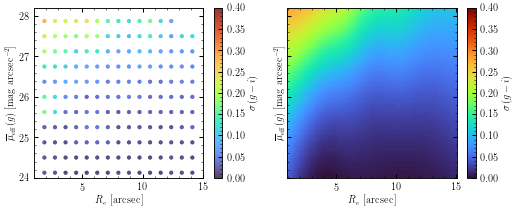

In [90]:
gi_bias_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gi_truth - gi_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 2, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='median',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.1, vmax=0.1, cbar_label=r'$\Delta(g-i)$'
)

gi_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gi_truth - gi_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g-i)$'
)

(-0.3, 1.4)

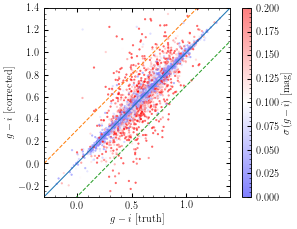

In [91]:
gi_meas_corr = gi_meas + gi_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T)
gi_meas_std = gi_std_rbf(np.vstack([re_meas, SB_meas['g']]).T)
gi_meas_std[gi_meas_std < 0.05] = 0.05

plt.scatter(gi_truth, gi_meas_corr, 
            c=gi_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.2,
            s=5, alpha=0.5)
x = np.linspace(-0.3, 1.4, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.colorbar(label=r'$\sigma(g-i)$ [mag]')
plt.xlabel(r'$g-i$ [truth]')
plt.ylabel(r'$g-i$ [corrected]')
plt.xlim(-0.3, 1.4)
plt.ylim(-0.3, 1.4)

In [92]:
joblib.dump(gi_bias_rbf, './Catalog/mock_sample/spergel/bias_std/color/gi_bias_rbf.pkl')
joblib.dump(gi_std_rbf, './Catalog/mock_sample/spergel/bias_std/color/gi_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/color/gi_std_rbf.pkl']

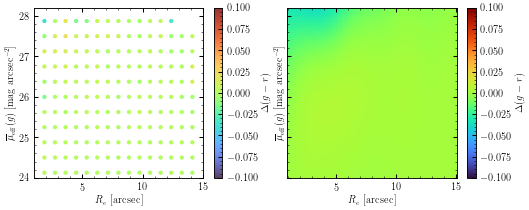

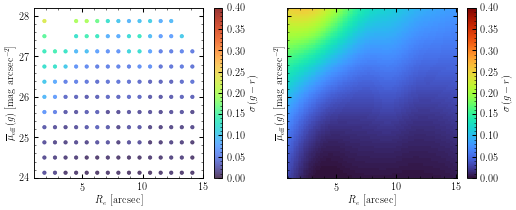

In [93]:
gr_bias_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gr_truth - gr_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 2, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='median',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.1, vmax=0.1, cbar_label=r'$\Delta(g-r)$'
)

gr_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gr_truth - gr_meas,
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    max_value=1,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g-r)$'
)

(-0.3, 1.4)

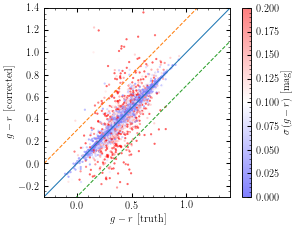

In [94]:
gr_meas_corr = gr_meas + gr_bias_rbf(np.vstack([re_meas, SB_meas['g']]).T)
gr_meas_std = gr_std_rbf(np.vstack([re_meas, SB_meas['g']]).T)
gr_meas_std[gr_meas_std < 0.05] = 0.05

plt.scatter(gr_truth, gr_meas_corr, 
            c=gr_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.2,
            s=5, alpha=0.5)
x = np.linspace(-0.3, 1.4, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.colorbar(label=r'$\sigma(g-r)$ [mag]')
plt.xlabel(r'$g-r$ [truth]')
plt.ylabel(r'$g-r$ [corrected]')
plt.xlim(-0.3, 1.4)
plt.ylim(-0.3, 1.4)

In [95]:
joblib.dump(gr_bias_rbf, './Catalog/mock_sample/spergel/bias_std/color/gr_bias_rbf.pkl')
joblib.dump(gr_std_rbf, './Catalog/mock_sample/spergel/bias_std/color/gr_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/color/gr_std_rbf.pkl']

### magnitudes 

In [98]:
mag_meas_corr = {}
mag_meas_std = {}

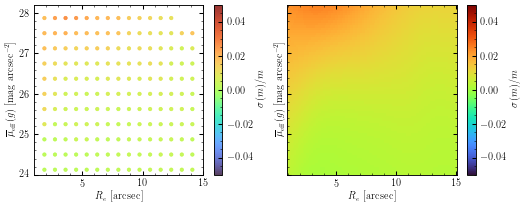

In [102]:
filt = 'g'
mag_meas_corr[filt] = SB_meas_corr[filt] - 2.5 * np.log10(2 * np.pi * re_meas_corr**2)

mag_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (mag_truth[filt] - mag_meas_corr[filt]) / mag_meas_corr[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.05, vmax=0.05, cbar_label=r'$\sigma(m)/m$'
)

mag_meas_std[filt] = mag_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * mag_meas_corr[filt]
mag_meas_std[filt][mag_meas_std[filt] < 0.05] = 0.05

0.003915108255263533


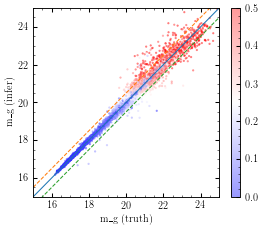

In [103]:
print(np.median(mag_truth[filt] - mag_meas_corr[filt]))
plt.scatter(mag_truth[filt], 
            mag_meas_corr[filt],
            c=mag_meas_std[filt], 
            cmap='bwr', s=5, alpha=0.4,
            vmin=0.,
            vmax=0.5,)

plt.xlim(15, 25)
plt.ylim(15, 25)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xlabel(f'm_{filt} (truth)')
plt.ylabel(f'm_{filt} (infer)')
plt.colorbar()

In [105]:
joblib.dump(mag_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/mag/{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/mag/g_std_rbf.pkl']

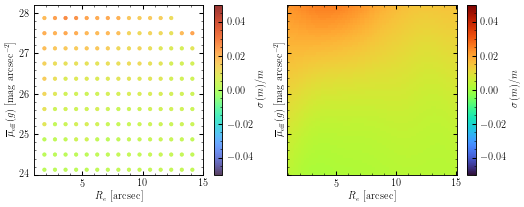

In [106]:
filt = 'i'
mag_meas_corr[filt] = mag_meas_corr['g'] - (gi_meas_corr)

mag_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (mag_truth[filt] - mag_meas_corr[filt]) / mag_meas_corr[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.05, vmax=0.05, cbar_label=r'$\sigma(m)/m$'
)

mag_meas_std[filt] = mag_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * mag_meas_corr[filt]
mag_meas_std[filt][mag_meas_std[filt] < 0.05] = 0.05

0.0037267009260659734


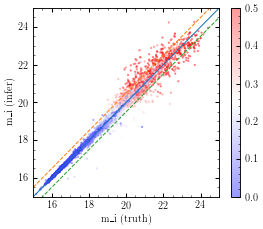

In [107]:
print(np.median(mag_truth[filt] - mag_meas_corr[filt]))

plt.scatter(mag_truth[filt], 
            mag_meas_corr[filt],
            c=mag_meas_std[filt], 
            cmap='bwr', s=5, alpha=0.4,
            vmin=0.,
            vmax=0.5,)

plt.xlim(15, 25)
plt.ylim(15, 25)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xlabel(f'm_{filt} (truth)')
plt.ylabel(f'm_{filt} (infer)')
plt.colorbar()

In [108]:
joblib.dump(mag_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/mag/{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/mag/i_std_rbf.pkl']

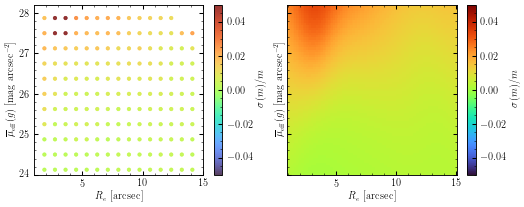

In [109]:
filt = 'r'
mag_meas_corr[filt] = mag_meas_corr['g'] - (gr_meas_corr)

mag_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (mag_truth[filt] - mag_meas_corr[filt]) / mag_meas_corr[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.05, vmax=0.05, cbar_label=r'$\sigma(m)/m$'
)

mag_meas_std[filt] = mag_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * mag_meas_corr[filt]
mag_meas_std[filt][mag_meas_std[filt] < 0.05] = 0.05

0.0030823341521362124


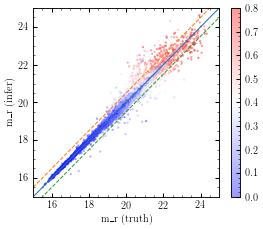

In [112]:
print(np.median(mag_truth[filt] - mag_meas_corr[filt]))

plt.scatter(mag_truth[filt], 
            mag_meas_corr[filt],
            c=mag_meas_std[filt], 
            cmap='bwr', s=5, alpha=0.4,
            vmin=0.,
            vmax=0.8,)

plt.xlim(15, 25)
plt.ylim(15, 25)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xlabel(f'm_{filt} (truth)')
plt.ylabel(f'm_{filt} (infer)')
plt.colorbar()

In [111]:
joblib.dump(mag_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/mag/{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/mag/r_std_rbf.pkl']

### SB

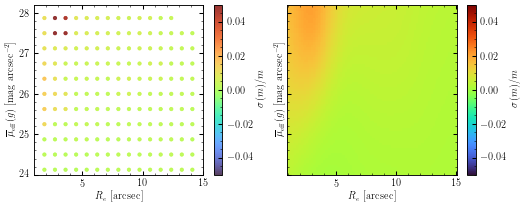

In [118]:
filt = 'r'
SB_meas_corr[filt] = SB_meas_corr['g'] - (gr_meas_corr)

SB_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (SB_truth[filt] - SB_meas_corr[filt]) / SB_meas_corr[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.05, vmax=0.05, cbar_label=r'$\sigma(m)/m$'
)

SB_meas_std[filt] = SB_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * SB_meas_corr[filt]
SB_meas_std[filt][SB_meas_std[filt] < 0.05] = 0.05

-0.0004936127273538204


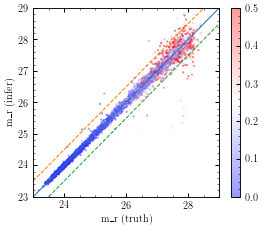

In [119]:
print(np.median(SB_truth[filt] - SB_meas_corr[filt]))

plt.scatter(SB_truth[filt], 
            SB_meas_corr[filt],
            c=SB_meas_std[filt], 
            cmap='bwr', s=5, alpha=0.4,
            vmin=0.,
            vmax=0.5,)

plt.xlim(23, 29)
plt.ylim(23, 29)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xlabel(f'm_{filt} (truth)')
plt.ylabel(f'm_{filt} (infer)')
plt.colorbar()

In [115]:
joblib.dump(SB_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/SB/{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/SB/r_std_rbf.pkl']

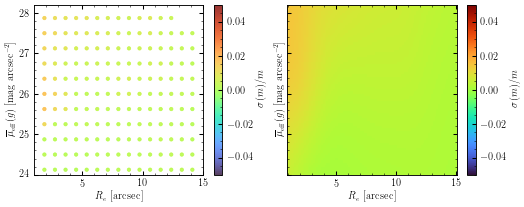

In [124]:
filt = 'i'
SB_meas_corr[filt] = SB_meas_corr['g'] - (gi_meas_corr)

SB_std_rbf = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    (SB_truth[filt] - SB_meas_corr[filt]) / SB_meas_corr[filt],
    n_slide=[2, 2],
    n_bins=[8, 8],
    _range=[[1, 15], [23, 29]],
    method='RBF',
    kernel_kwargs={'smoothing': 1, 'kernel': 'multiquadric', 'epsilon': 0.5},
    statistic='std',
    min_value=None,
    min_num=20,
    degree=2,
    ylim=[24, 28.2], vmin=-0.05, vmax=0.05, cbar_label=r'$\sigma(m)/m$'
)

SB_meas_std[filt] = SB_std_rbf(np.vstack([re_meas, SB_meas['g']]).T) * SB_meas_corr[filt]
SB_meas_std[filt][SB_meas_std[filt] < 0.05] = 0.05

1.1218850790584156e-05


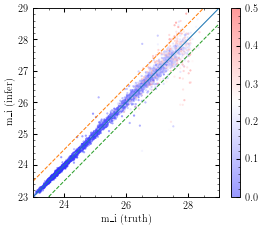

In [125]:
print(np.median(SB_truth[filt] - SB_meas_corr[filt]))

plt.scatter(SB_truth[filt], 
            SB_meas_corr[filt],
            c=SB_meas_std[filt], 
            cmap='bwr', s=5, alpha=0.4,
            vmin=0.,
            vmax=0.5,)

plt.xlim(23, 29)
plt.ylim(23, 29)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xlabel(f'm_{filt} (truth)')
plt.ylabel(f'm_{filt} (infer)')
plt.colorbar()

In [126]:
joblib.dump(SB_std_rbf, f'./Catalog/mock_sample/spergel/bias_std/SB/{filt}_std_rbf.pkl')

['./Catalog/mock_sample/spergel/bias_std/SB/i_std_rbf.pkl']

#### solved
re, SB_g, thus m_g

g-r, g-i, thus m_r, m_i

thus
SB_r, SB_i

---

In [181]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=17)

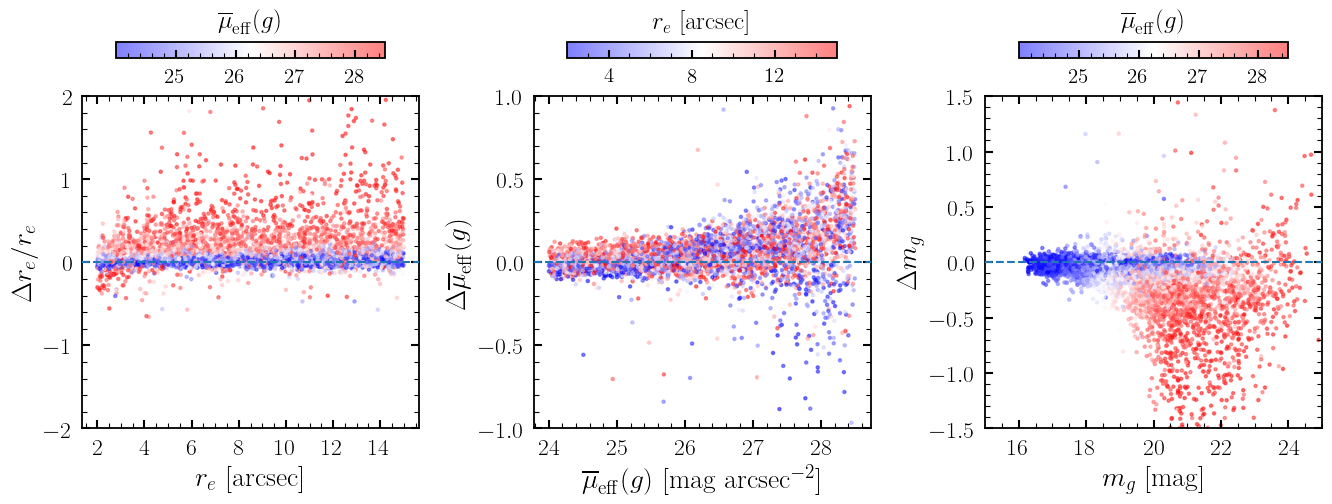

In [194]:
labelsize = 20

fig, axes = plt.subplots(1, 3, figsize=(16., 4.4), sharey=False, sharex=False)

ax = axes[0]
plt.sca(ax)
sct = plt.scatter(re_truth, (re_truth - re_meas) / re_meas, c=SB_truth['g'], 
            cmap='bwr',
            s=5, alpha=0.5, rasterized=True)
plt.axhline(0, ls='--', zorder=10)
plt.xticks(ticks=np.arange(2, 15, 2))
plt.xlabel(r'$r_e$ [arcsec]', fontsize=labelsize)
plt.ylabel(r'$\Delta r_e/r_e$', fontsize=labelsize)
# plt.xlim(2, 15)
plt.ylim(-2, 2)
ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(sct, cax=ax_cbar, orientation='horizontal',
                    ticks=[25, 26, 27, 28])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\overline{\mu}_{\rm eff} (g)$', size=18)

ax = axes[1]
plt.sca(ax)
filt = 'g'
sct = plt.scatter(SB_truth[filt], (SB_truth[filt] - SB_meas[filt]),
            cmap='bwr',
            c=re_truth, s=5, alpha=0.5, rasterized=True)
plt.axhline(0, ls='--', zorder=10)
plt.xticks(ticks=np.arange(24, 29, 1))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)
plt.ylabel(r'$\Delta \overline{\mu}_{\rm eff} (g)$', fontsize=labelsize)
# plt.xlim(24, 28)
# plt.ylim(-0.05, 0.05)
plt.ylim(-1, 1)
ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(sct, cax=ax_cbar, orientation='horizontal',
                    ticks=[4, 8, 12])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$r_e$ [arcsec]', size=18)

ax = axes[2]
plt.sca(ax)
filt = 'g'
sct = plt.scatter(mag_truth[filt], (mag_truth[filt] - mag_meas[filt]), # / (mag_meas[filt]), 
                  cmap='bwr',
                  c=SB_truth['g'], 
                  s=5, alpha=0.5, rasterized=True)
plt.axhline(0, ls='--', zorder=10)
plt.xticks(ticks=np.arange(14, 26, 2))
plt.xlabel(f'$m_{filt}$ [mag]', fontsize=labelsize)
plt.ylabel(f'$\Delta m_{filt}$', fontsize=labelsize)
plt.xlim(15, 25)
# plt.ylim(-0.05, 0.05)
plt.ylim(-1.5, 1.5)
ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(sct, cax=ax_cbar, orientation='horizontal',
                    ticks=[25, 26, 27, 28])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\overline{\mu}_{\rm eff} (g)$', size=18)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.34)

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/meas_bias.pdf', 
            bbox_inches='tight')